In [15]:
import pandas as pd
import numpy as np
import random

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
%cd /content/drive/MyDrive/

/content/drive/MyDrive


In [6]:
df = pd.read_pickle('all_comments_translated.pkl')

## word cloud generation

In [ ]:
df = pd.read_pickle('special_for_ori.pkl')

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import string
to_cloud = df[(df['country'] == 'United Kingdom') & (df['weak_label'] == 0)]
to_cloud['comment_no_stop'] = to_cloud['translated'].apply(lambda c: ' '.join([word.lower() for word in c.split() if word not in (stopwords.words('english'))]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
with open('uk_weak_0_all.txt', 'a') as the_file:
   for c in to_cloud['comment_no_stop']:
      the_file.write(" " + c)

In [ ]:
with open('uk_weak_0_all.txt', 'r') as the_file:
  with open('uk_weak_0_all_brex.txt', 'a') as brex_file:
    for l in the_file:
      for w in l.split():
        if "brex" in w:
          brex_file.write(" Brexit ")
        brex_file.write(" " + w)
      # for c in to_cloud['comment_no_stop']:
      #     the_file.write(c)

## Labeling

In [ ]:
index = random.randint(0, len(df))
df.loc[index, 'translated']

'Soner Sarıkabadayı... My favorite singer'

In [ ]:
df.loc[index, 'label'] = 1

In [ ]:
df.loc[index, 'label'] = 0

In [ ]:
df.loc[index, 'label'] = np.NaN

Saving file

In [ ]:
pd.to_pickle(df, 'all_comments_translated.pkl')

## Training

In [ ]:
X_train = df[(df['label'] == 0) | (df['label'] == 1)]['translated'].values
y_train = df[(df['label'] == 0) | (df['label'] == 1)]['label'].values.astype(int)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [ ]:
!pip install transformers

     |████████████████████████████████| 2.6 MB 8.5 MB/s 
     |████████████████████████████████| 636 kB 41.9 MB/s 
     |████████████████████████████████| 3.3 MB 55.6 MB/s 
     |████████████████████████████████| 895 kB 64.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from transformers import BertForSequenceClassification, BertTokenizerFast

In [ ]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased', do_lower_case=True)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
encoded_input = tokenizer(X_train.tolist(), truncation=True, padding=True, max_length=512, return_tensors='pt')
encoded_val = tokenizer(X_val.tolist(), truncation=True, padding=True, max_length=512, return_tensors='pt')

In [ ]:
import torch
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: v[idx] for k, v in self.encodings.items()}
        item["labels"] = torch.tensor([self.labels[idx]])
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
train_dataset = MyDataset(encoded_input, y_train)
val_dataset = MyDataset(encoded_val, y_val)

In [ ]:
from transformers import TrainingArguments, Trainer

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=100,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=20,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    load_best_model_at_end=True,     # load the best model when finished training (default metric is loss)
    evaluation_strategy="steps",     # evaluate each `logging_steps`
)

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  # calculate accuracy using sklearn's function
  acc = accuracy_score(labels, preds)
  return {
      'accuracy': acc,
  }

In [ ]:
trainer = Trainer(
    model=model,                         # the instantiated Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,          # evaluation dataset
    compute_metrics=compute_metrics,     # the callback that computes metrics of interest
)

In [ ]:
trainer.train()

***** Running training *****
  Num examples = 506
  Num Epochs = 100
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 3200


Step,Training Loss,Validation Loss,Accuracy
500,0.205200,0.417771,0.921260
1000,0.034500,0.590775,0.921260
1500,0.029400,0.738441,0.905512
2000,0.022900,0.880318,0.881890
2500,0.025300,0.737417,0.905512
3000,0.023300,0.757439,0.905512


***** Running Evaluation *****
  Num examples = 127
  Batch size = 20
Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 127
  Batch size = 20
Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.json
Model weights saved in ./results/checkpoint-1000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 127
  Batch size = 20
Saving model checkpoint to ./results/checkpoint-1500
Configuration saved in ./results/checkpoint-1500/config.json
Model weights saved in ./results/checkpoint-1500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 127
  Batch size = 20
Saving model checkpoint to ./results/checkpoint-2000
Configuration saved in ./results/checkpoint-2000/config.json
Model weights saved in ./results/checkpoint-2000/pytorch_model.bin

TrainOutput(global_step=3200, training_loss=0.05478592351078987, metrics={'train_runtime': 752.1953, 'train_samples_per_second': 67.27, 'train_steps_per_second': 4.254, 'total_flos': 2964316038552000.0, 'train_loss': 0.05478592351078987, 'epoch': 100.0})

In [ ]:
trainer.evaluate()

In [ ]:
model.save_pretrained('./my_model')

Configuration saved in ./my_model2/config.json
Model weights saved in ./my_model2/pytorch_model.bin


## Generating weak labels

In [ ]:
def get_prediction(text):
    # prepare our text into tokenized sequence
    inputs = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors="pt").to("cuda")
    # perform inference to our model
    outputs = model(**inputs)
    # get output probabilities by doing softmax
    probs = outputs[0].softmax(1)
    # executing argmax function to get the candidate label
    # return target_names[probs.argmax()]
    return probs.argmax()

In [ ]:
df['weak_label'] = df['translated'].apply(lambda text: get_prediction(text).item())

saving

In [ ]:
pd.to_pickle(df, 'all_comments_translated_weak.pkl')

## Using weak labels to get some statistics

In [18]:
df = pd.read_pickle('all_comments_translated_weak.pkl')

In [19]:
df.head()

,totalReplyCount,id,likeCount,publishedAt,updatedAt,textDisplay,textOriginal,replies,videoId,translated,label,weak_label
0,461,Ugz5enNyRnrNijms3ml4AaABAg,2780,2021-03-10T09:01:28Z,2021-04-16T15:16:55Z,Add or download the song to your playlist: <a ...,Add or download the song to your playlist: htt...,"{'comments': [{'kind': 'youtube#comment', 'eta...",l01wa2ChX64,Add or download the song to your playlist: htt...,NaN,0
1,0,Ugz5iM0F35SrrmPeXXJ4AaABAg,0,2021-06-12T02:12:17Z,2021-06-12T02:12:17Z,ну и кринж господи ты боже,ну и кринж господи ты боже,[],l01wa2ChX64,"well and krinzh, oh my god",NaN,0
2,0,Ugx9UVEC2VoeXZpCQb94AaABAg,0,2021-06-12T01:57:11Z,2021-06-12T01:57:11Z,i don&#39;t get this amount of dislikes.. so u...,i don't get this amount of dislikes.. so unfair,[],l01wa2ChX64,i don't get this amount of dislikes.. so unfair,NaN,1
3,0,UgwXOcpHzO8QN8apIrl4AaABAg,0,2021-06-11T19:28:48Z,2021-06-11T19:28:48Z,Незнаю как вам для меня это шок куда катимся 😣😣😣,Незнаю как вам для меня это шок куда катимся 😣😣😣,[],l01wa2ChX64,I don’t know how you shock me where we’re going,NaN,0
4,0,UgzFR4vi7dcmsjvBHtx4AaABAg,0,2021-06-11T16:42:01Z,2021-06-11T16:42:01Z,Это же просто ужас,Это же просто ужас,[],l01wa2ChX64,It&#39;s just awful,NaN,1


### add title to each comment by the videoId

In [20]:
metadata = pd.read_csv('videos_metadata.csv')

In [21]:
df = df[df['videoId'].notna()]

In [22]:
videos_names_dict = pd.Series(metadata.title.values, metadata.videoId).to_dict()

In [23]:
df['title'] = df['videoId'].apply(lambda id: videos_names_dict[id])

In [24]:
group = df.groupby('title')

In [25]:
weak_mean_dict = group.weak_label.mean().to_dict()

In [26]:
weak_mean_dict = dict(sorted(weak_mean_dict.items(), key=lambda item: item[1]))

In [27]:
df.head()

,totalReplyCount,id,likeCount,publishedAt,updatedAt,textDisplay,textOriginal,replies,videoId,translated,label,weak_label,title
0,461,Ugz5enNyRnrNijms3ml4AaABAg,2780,2021-03-10T09:01:28Z,2021-04-16T15:16:55Z,Add or download the song to your playlist: <a ...,Add or download the song to your playlist: htt...,"{'comments': [{'kind': 'youtube#comment', 'eta...",l01wa2ChX64,Add or download the song to your playlist: htt...,NaN,0,Manizha - Russian Woman - Russia 🇷🇺 - Official...
1,0,Ugz5iM0F35SrrmPeXXJ4AaABAg,0,2021-06-12T02:12:17Z,2021-06-12T02:12:17Z,ну и кринж господи ты боже,ну и кринж господи ты боже,[],l01wa2ChX64,"well and krinzh, oh my god",NaN,0,Manizha - Russian Woman - Russia 🇷🇺 - Official...
2,0,Ugx9UVEC2VoeXZpCQb94AaABAg,0,2021-06-12T01:57:11Z,2021-06-12T01:57:11Z,i don&#39;t get this amount of dislikes.. so u...,i don't get this amount of dislikes.. so unfair,[],l01wa2ChX64,i don't get this amount of dislikes.. so unfair,NaN,1,Manizha - Russian Woman - Russia 🇷🇺 - Official...
3,0,UgwXOcpHzO8QN8apIrl4AaABAg,0,2021-06-11T19:28:48Z,2021-06-11T19:28:48Z,Незнаю как вам для меня это шок куда катимся 😣😣😣,Незнаю как вам для меня это шок куда катимся 😣😣😣,[],l01wa2ChX64,I don’t know how you shock me where we’re going,NaN,0,Manizha - Russian Woman - Russia 🇷🇺 - Official...
4,0,UgzFR4vi7dcmsjvBHtx4AaABAg,0,2021-06-11T16:42:01Z,2021-06-11T16:42:01Z,Это же просто ужас,Это же просто ужас,[],l01wa2ChX64,It&#39;s just awful,NaN,1,Manizha - Russian Woman - Russia 🇷🇺 - Official...


In [28]:
eurovision_years = metadata.year.unique().tolist()
eurovision_years

[2021, 2019, 2018, 2017]

In [29]:
points_df = pd.read_csv('total_points_by_country_televoting_jury.csv')

## try to find correlation between the song's points by jury/televoting to the proportion of song related comments

### Jury 

In [30]:
group_by_year_jury = points_df[(points_df.final == 'f') & (points_df.year >= 2017) & (points_df.votetype == 'J')].groupby('year')

In [31]:
x = []
y = []
ranks = []
flag = False
for year in eurovision_years:
    sorted_group = group_by_year_jury.get_group(year).sort_values('points', ascending=False)
    sorted_group['euro_rank'] = range(1, len(sorted_group) + 1)
    country_list = zip(sorted_group.countryto.values.tolist(), sorted_group.points.values.tolist(), sorted_group.euro_rank.values.tolist())
    for country, points, rank in country_list:
        temp = metadata[(metadata.year == year) & (metadata.title.str.contains(country))]
        if temp.empty or len(temp) > 1:
            # print(country, year)
            if len(temp) > 1:
                flag = True
                temp = temp.iloc[1]
                # print(temp.title)
            else:
                raise ValueError("error")
        if flag:
            weak, point = weak_mean_dict[temp.title], points
            flag = False
        else:
            weak, point = weak_mean_dict[temp.title.iloc[0]], points
        x.append(weak)
        y.append(point)
        ranks.append(rank)
        # print(temp)

In [32]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'points')

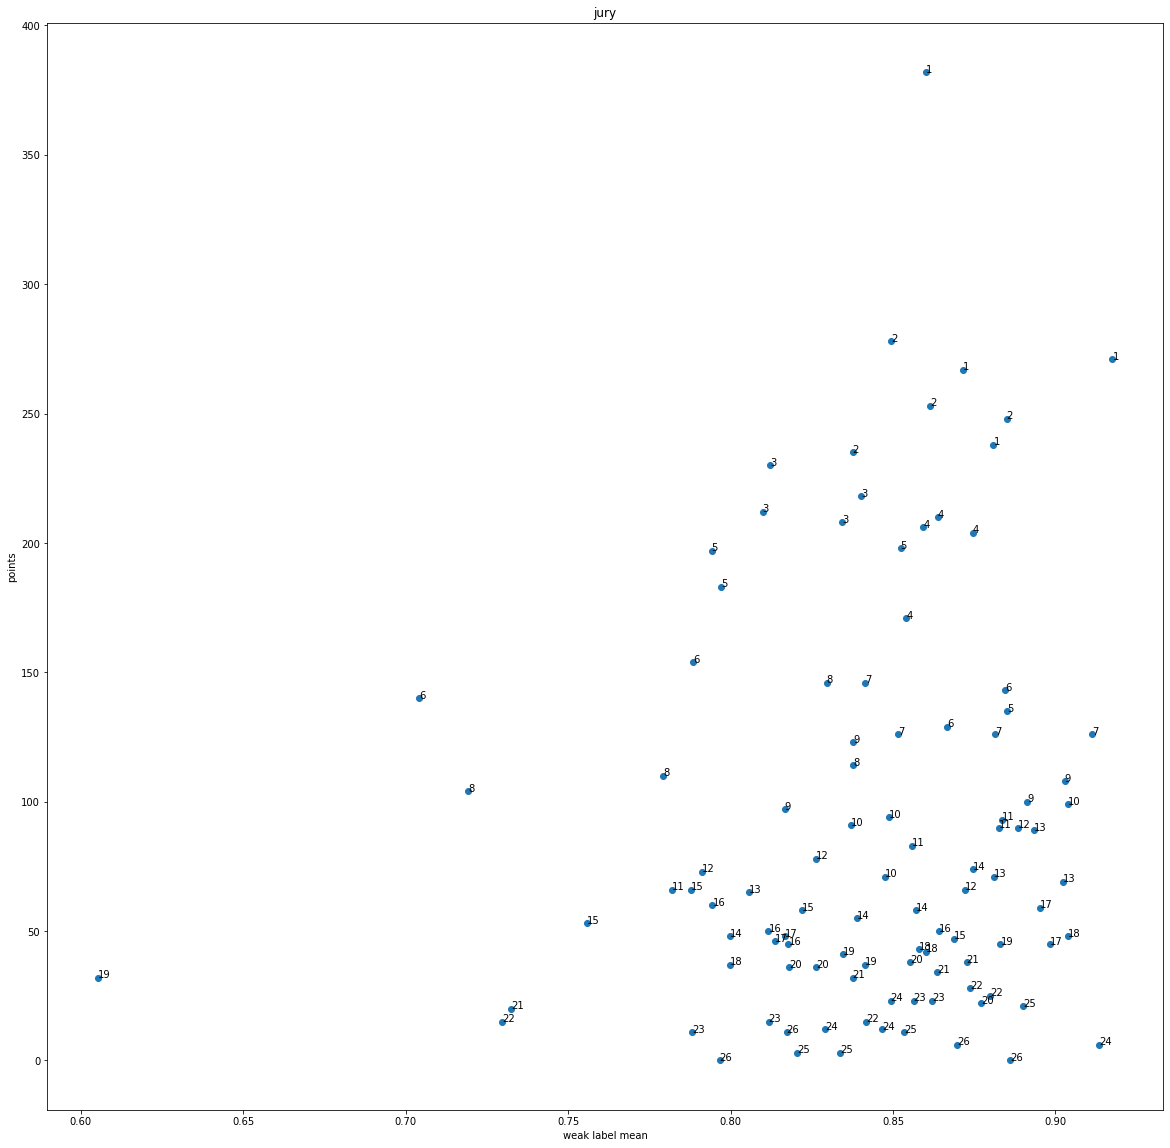

In [33]:
fig, ax = plt.subplots(figsize=(20, 20))
ax.scatter(x, y)
for i, txt in enumerate(ranks):
    ax.annotate(txt, (x[i], y[i]))
ax.set_title('jury')
ax.set_xlabel('weak label mean')
ax.set_ylabel('points')

### televoting

In [34]:
group_by_year_televoting = points_df[(points_df.final == 'f') & (points_df.year >= 2017) & (points_df.votetype == 'T')].groupby('year')

In [35]:
x = []
y = []
ranks = []
flag = False
for year in eurovision_years:
    sorted_group = group_by_year_televoting.get_group(year).sort_values('points', ascending=False)
    sorted_group['euro_rank'] = range(1, len(sorted_group) + 1)
    country_list = zip(sorted_group.countryto.values.tolist(), sorted_group.points.values.tolist(), sorted_group.euro_rank.values.tolist())
    for country, points, rank in country_list:
        temp = metadata[(metadata.year == year) & (metadata.title.str.contains(country))]
        if temp.empty or len(temp) > 1:
            if len(temp) > 1:
                flag = True
                temp = temp.iloc[1]
                # print(temp.title)
            else:
                raise ValueError("error")
        if flag:
            weak, point = weak_mean_dict[temp.title], points
            flag = False
        else:
            weak, point = weak_mean_dict[temp.title.iloc[0]], points
        x.append(weak)
        y.append(point)
        ranks.append(rank)

Text(0, 0.5, 'points')

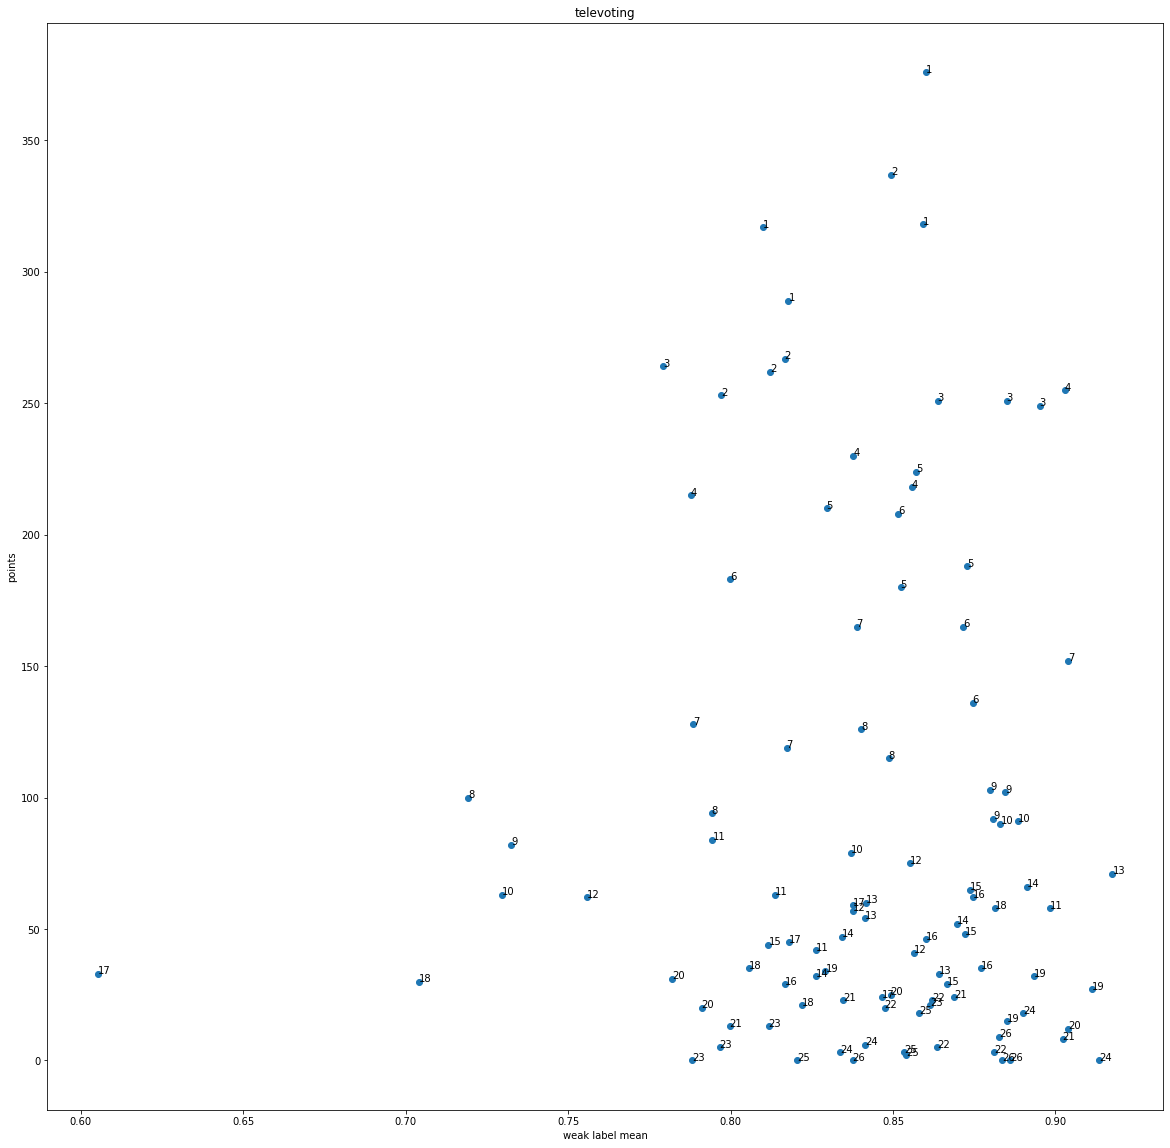

In [36]:
fig, ax = plt.subplots(figsize=(20, 20))
ax.scatter(x, y)
for i, txt in enumerate(ranks):
    ax.annotate(txt, (x[i], y[i]))
ax.set_title('televoting')
ax.set_xlabel('weak label mean')
ax.set_ylabel('points')

### song related proportion for each country

In [37]:
df.groupby('country').mean()['weak_label'].sort_values()

KeyError: ignored